In [44]:
using Statistics, StatsBase, JLD, Random
using LinearAlgebra, IntervalArithmetic
using PyPlot

setprecision(BigFloat,196)
const T = Interval{BigFloat} # yeah high precision intervals baby
const p = T.((180//100,35//100))
const p2m = Float64(mid(p[2]))
const N = 40000; # how many cool_intervals calls per sim
const K = 6; const Kstep = 10; # how long to push forward for

include("../simulations/cool-intervals.jl")

cool_intervals (generic function with 1 method)

In [45]:
# start with the backward-invariant unstable manifold between w_0 and w_1
beta = (p[1]-sqrt(p[1]^2+4p[2]))/2; alpha = -beta/(1+beta)
x_ref_end = -alpha/beta; x_ref_start = 1-p[1]*x_ref_end
Q = [1 -beta; beta 1]/sqrt(1+beta*beta)
Is = Q[2,:]*alpha .+ sqrt(1+beta*beta)*T.([1,0])*[x_ref_start x_ref_end]

# spinup
for i = 1:10000
    Is, Q, c, cw = cool_intervals(Is,Q,p)
end

attractor_endpts = Array{Float64}(undef,2,2,N)
sigma_pts = Array{Float64}(undef,N)
sigma_wts = Array{Float64}(undef,N)
sigma_pushforward = Array{Float64}(undef,2,K,N)
for i = 1:N
    Is, Q, c, cw = cool_intervals(Is,Q,p)
    attractor_endpts[:,:,i] = Float64.(mid.(Q*Is))
    sigma_pts[i] = Float64.(mid.(c)); sigma_wts[i] = Float64.(mid.(cw))
    if ~isnan(c)
        x = [0,c]
        for k = 1:K
            sigma_pushforward[:,k,i] = Float64.(mid.(x))
            for u = 1:Kstep
                smap!(x,p)
            end
        end
    end
end
samplen = (.~)(isnan.(sigma_pts))
sigma_pts = sigma_pts[samplen]
sigma_wts = sigma_wts[samplen]
sigma_pushforward = sigma_pushforward[:,:,samplen];

In [46]:
function attractor_plot_base()
    lines = [attractor_endpts[:,:,i]'  ./ [1,p2m]' for i = 1:2000]

    lwl = [1 ./norm(l[1,:] - l[2,:]) for l in lines]; lwl /= 3mean(lwl); lwl = min.(lwl,1)
    gca().set_aspect("equal")
    attractor = matplotlib.collections.LineCollection(lines,
            linewidth=1.0,colors=[zeros(length(lines),3) lwl],zorder=2,label="Attractor \$\\Lambda\$")
    gca().add_collection(attractor)

    #plot([0,0],[-10,10],"green",label="\$\\mathcal{S}\$",zorder=1); ylim(-0.7076475276167904, 0.7374277623133827)
    # scatter(zeros(length(ch[1:1000])),Float64.(mid.(ch[1:1000])),c="C1",label="\$\\mathcal{S} \\cap \\Lambda\$: support of \$\\rho_\\mathcal{S}\$",s=1,zorder=3)
#     xlabel("\$x\$"); ylabel("\$y\$")

    # legend()
    tight_layout()
end

attractor_plot_base (generic function with 1 method)

In [17]:
sum(sigma_pushforward[2,5,:])

446.0108932673576

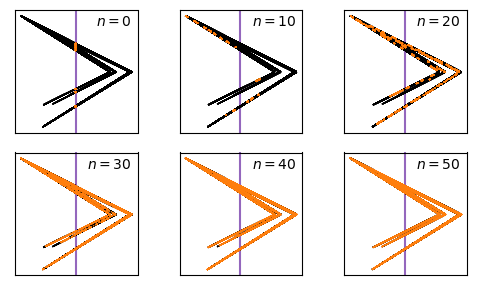

((-1.3073240592299922, 1.3352316636712327), (-1.3073240592299924, 1.3352316636712327))

In [52]:
figure(figsize=(6,3))
for k = [collect(1:4);6]
    subplot(2,3,k)
    attractor_plot_base()
    yticks([]); xticks([])
    scatter(sigma_pushforward[1,k,:],
       sigma_pushforward[2,k,:]/p2m,s=1.2,c="C1",zorder=3,ec="none")
#     plt.text(0.98,0.98,"\$n=$k\$",va="top",ha="right",transform=gca().transAxes)
    ylim(ylim()); plot([0,0],ylim(),"C4",zorder=1)
    text(0.95,0.9,"\$n=$(Kstep*(k-1))\$",ha="right",va="center",transform = gca().transAxes)
end
for k = 5 # lol wtf
    subplot(2,3,k)
    attractor_plot_base()
    yticks([]); xticks([])
    scatter(sigma_pushforward[1,k,:],
       sigma_pushforward[2,k,:]/p2m,s=1.2,c="C1",zorder=3,ec="none")
#     plt.text(0.98,0.98,"\$n=$k\$",va="top",ha="right",transform=gca().transAxes)
    ylim(ylim()); plot([0,0],ylim(),"C4",zorder=1)
    text(0.95,0.9,"\$n=$(Kstep*(k-1))\$",ha="right",va="center",transform = gca().transAxes)
end

tight_layout()
savefig("../figures/Covering.png",dpi=500)
xlim(), ylim()